In [90]:
# Imports
import pandas as pd
import math
import time 
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns

In [91]:
# Constants
DATA_PATH = 'NewGeneratedData/'
MODELS_PATH = 'Models/'

BATCH_SIZE = 32
EPOCHS = 75

EARLY_STOP = True
EARLY_STOP_LEN = 10

RECORD = True     
model_name = "cnn_11"

In [92]:
# Loading functions
def load_data_frame(txt):
    return pd.read_csv(DATA_PATH + txt + '.txt', header=None, sep='\s+')

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/lt/w0169b7x5ml3psz3nly9vj3m0000gn/T/ipykernel_39389/3443055661.py:3: SyntaxWarning: invalid escape sequence '\s'
  return pd.read_csv(DATA_PATH + txt + '.txt', header=None, sep='\s+')


In [93]:
FEATURES = load_data_frame("features")[0].to_list()

complete_set = load_data_frame("har_dataset")
complete_set.columns = FEATURES
train_set, test_set = train_test_split(complete_set, test_size=0.3, random_state=37)

activity_labels = load_data_frame('activity_labels')
activity_labels.columns = ['id', 'activity']

In [94]:
# Creating model
device = None

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

class OurModel(nn.Module):
    def __init__(self):
        super(OurModel, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(in_features=len(FEATURES) - 1, out_features=768),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(in_features=768, out_features=256),
            nn.BatchNorm1d(256),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=12),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

In [95]:
model = OurModel().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [96]:
# Training and testing function
def train(dataloader, model, loss_fn, optimizer):
    # Get batch num
    num_batches = len(dataloader.dataset) / BATCH_SIZE
    i = 0

    # Set the model to train mode
    model.train()

    # For early stopping
    tracking_prev_loss = []

    for batch, (X, y) in enumerate(dataloader):
        X = X.unsqueeze(-1)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (EARLY_STOP):
            if len(tracking_prev_loss) == 0: 
                tracking_prev_loss.append(loss.item())
            else:
                if tracking_prev_loss[-1] >= loss.item():
                    tracking_prev_loss.append(loss.item())
                    if len(tracking_prev_loss) == EARLY_STOP_LEN:
                        return
                else:
                    tracking_prev_loss = []

        i += 1
        if batch % 50 == 0:
            print(f"loss: {loss.item()}, batch: {i} out of {math.ceil(num_batches)}")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    true_labels, pred_labels = [], []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.unsqueeze(-1)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            true_labels.extend(y.tolist())
            pred_labels.extend(pred.argmax(1).tolist())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    return (f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"), confusion_matrix(true_labels, pred_labels)

In [97]:
# Dataset preparation
class HAPTDataset(Dataset):
    def __init__(self, dataset, features, label):
        self.data = torch.tensor(dataset[features].values, dtype=torch.float32)
        self.labels = torch.tensor(dataset[label].values, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
train_dataset = HAPTDataset(train_set, train_set.columns[:-1], 'activity')
test_dataset = HAPTDataset(test_set, test_set.columns[:-1], 'activity')

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [98]:
perf_timer = time.perf_counter()
perf_acc, conf_matrix = None, None
perf_list = []

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_function, optimizer)
    perf_acc, conf_matrix = test(test_dataloader, model, loss_function)
    perf_list.append(perf_acc)

print(perf_acc)
perf_timer = time.perf_counter() - perf_timer
conf_matrix = 100 * conf_matrix.astype('float')/ conf_matrix.sum(axis=1)[:, np.newaxis]
print("Done!")

Epoch 1
-------------------------------
loss: 2.4843714237213135, batch: 1 out of 266
loss: 2.211747884750366, batch: 51 out of 266
loss: 2.1644158363342285, batch: 101 out of 266
loss: 2.199748992919922, batch: 151 out of 266
loss: 2.1057262420654297, batch: 201 out of 266
loss: 1.9936439990997314, batch: 251 out of 266
Epoch 2
-------------------------------
loss: 2.0107994079589844, batch: 1 out of 266
loss: 2.062398910522461, batch: 51 out of 266
loss: 2.0545196533203125, batch: 101 out of 266
loss: 2.0980725288391113, batch: 151 out of 266
loss: 1.968023419380188, batch: 201 out of 266
loss: 2.1228392124176025, batch: 251 out of 266
Epoch 3
-------------------------------
loss: 1.920102834701538, batch: 1 out of 266
loss: 2.0043439865112305, batch: 51 out of 266
loss: 1.9958891868591309, batch: 101 out of 266
loss: 1.9841965436935425, batch: 151 out of 266
loss: 2.0310516357421875, batch: 201 out of 266
loss: 1.962146282196045, batch: 251 out of 266
Epoch 4
-----------------------

In [99]:
for item in perf_list:
    # print(item)
    pass

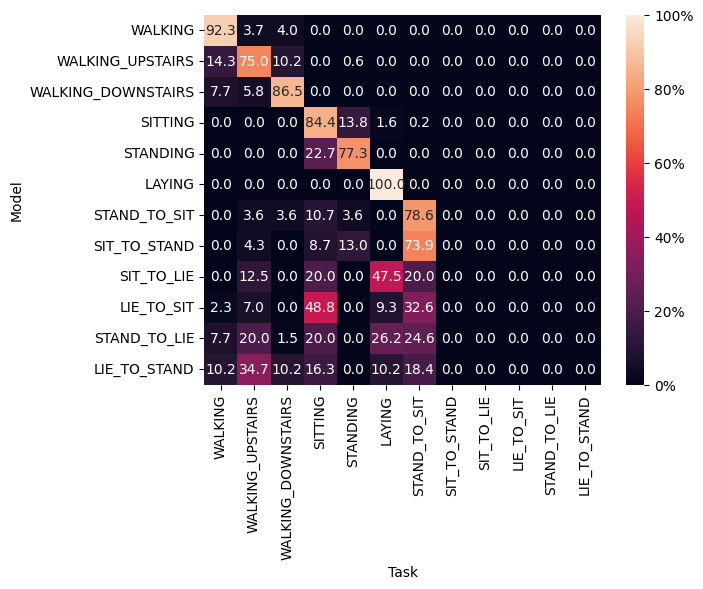

In [100]:
plot = sns.heatmap(conf_matrix, annot=True, fmt=".1f", cbar_kws={'format': '%.0f%%'}, xticklabels=activity_labels.activity, yticklabels=activity_labels.activity)
plot.set_xlabel("Task")
plot.set_ylabel("Model")

if RECORD:
    torch.save(model.state_dict(), MODELS_PATH + model_name + ".pth")

    with open(MODELS_PATH + model_name + ".txt", "w") as f:
        f.write("Epochs: {}\n".format(EPOCHS))
        f.write("Feature Selection: {}\n".format("MRMR"))
        f.write("Feature Set: {}\n".format(FEATURES))
        f.write("Model: {}\n".format(str(model)))
        f.write("Loss Function: {}\n".format("Cross Entropy Loss"))
        f.write("Optimizer: {}\n\n\n\n".format(str(optimizer)))
        f.write("Results: {}\n".format(perf_acc))
        f.write("Timer: {}s\n".format(round(perf_timer, 2)))
        f.close()

    plot.get_figure().savefig(MODELS_PATH + model_name + "_matrix.png")